###### 




## Aim of This Notebook

Aim of this notebook is to load and explore multi-sources datasets, prepare data for ML models, Train the regression model and return the metrics of RMSE and R_Squared, MAE. Lastly, visualize results of feature importance

We developed important functions to demonstrate training model, hyperparameter tuning, etc.

We choose the ML algorithms like random forest as a starting model because it can automatically return the feature importance scores.
Other ML models will be also explored and currently in the development phase

## Data Sources

Collection and Pre-processing all the datasets is one of the major components in this project. 

In this notebook, we used the following datasets after pre-processing (cleaning, interpolation, resampling, etc) of the raw data:
1. sentinel-1 InSAR coherence data products from September 2016 to November 2019,
2. Water Level data from EDEM gauge network 
3. Air Temperature and wind speed
4. Precipitation

## Citation
!! If you want to use our processed datasets and python codes for your research purpose, please cit our repository or the future coming paper. 


## Future Work

   Include data showing vegetation coverages in the whole Everglade region, and then conduct ML models for different vegetation areas, in order to answer the question: 
   1. How the feature importance different in different vegetation areas considering their effect on InSAR coherence variations?
   2. What are the optimal ML models for getting the most appropriate feature importance on InSAR coherence variations? Then we have better understanding about the most importance factors contributing to the local ecosystem change?
   
   
###  Import all the necessary python packages



In [12]:
import pandas as pd
import numpy as np
import os
import xlsxwriter
#!pip install xlsxwriter

# python packages related to ML modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# python packages related to model evaluation
from sklearn.metrics import r2_score  # R_2
from sklearn.metrics import mean_squared_error # RMSE
from sklearn.metrics import mean_absolute_error  # MAE

# python packages related to data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl



###  Design function randomforest_regressor to train ML model and predict target data

In [13]:
def randomforest_regressor(features, labels):
    # input:
    # features: datasets that are features or input of the ML model
    # labels: datasets that are target or output of the ML model
    
    # Output:
    # importances: a list of feature importances as calculated by the Random Forest Regressor
    # predictions: the predictions made by the trained model on the test data
    # train_features: the training features dataset
    # test_features: the testing features
    # train_labels: the training labels or targets
    # test_labels: the test labels or targets
    # RMSE: the calculated Root Mean Squared Error
    # R2: the calculated R-Squared
    # MAE: the calculated Mean Absolute Error
    
    # 1. Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3, random_state = 42)
    
    # 2. After getting the training and testing datasets, coonduct instantiate model
    # Several hyperparameters are set for the Random Forest Regressor
    rf = RandomForestRegressor(bootstrap = True,
                              max_depth = 40,
                              max_features = 3,
                              min_samples_leaf = 3,
                              min_samples_split = 7, 
                              n_estimators = 350,
                              random_state = 42)
    
    # 3. Train the model on training datasets
    rf.fit(train_features, train_labels)
    
    # 4. Test on the model and calculate the metrics
    predictions = rf.predict(test_features)
    # print(np.mean(predictions))
    
    # calculate RMSE 
    RMSE = np.sqrt(mean_squared_error(test_labels, predictions))
    
    # calculate R2
    R2 = r2_score(test_labels, predictions)
    
    # calculate MAE
    MAE = mae(test_labels, predictions) 
    
    print('Root Mean Squared Error: ', round(RMSE,2))
    
    print('R_Squared: ', round(R2,2))
    
    print('Mean Absolute Error: ', round(MAE,2))
    
    # output feature importance from the ML model
    importances = list(rf.feature_importances_)
    
    return importances, predictions, train_features, test_features, train_labels, test_labels, RMSE, R2, MAE

### Design a function "importance_Visualized" to visualize the calculated feature importance from ML model

In [14]:
def importance_Visualized(importances, feature_list, outpathfigure, filename):
    # Input:
    # importances: a list of feature importances as calculated by the ML model
    # feature_list:
    # outpathfigure: the file path points to where you want to save the output figure representing feature importances
    # filename: the name of the figure
    
    # Output:
    # generate a figure to the file path and name specified based on input
    
    # Generate a list of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    
    # Sort the feature importances in Descending order
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    
    # Print out the feature and importances
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
    
    # list of x locations for plotting, such as setting an index for each feature importance
    x_values = list(range(len(importances)))
    print(x_values)
    
    #plot features
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5), dpi=200)
    labels = feature_list
    x = np.arange(len(labels))  # the label indices
    
    #set the font for x,y labels in the plot
    label_font = {
        'weight': 'bold',
        'size': 8
    }
    
    #set size of title
    font={
        'weight': 'bold',
        'size': 10
    }
    
    # Set the style
    #plt.style.use('fivethirtyeight')
    
    #set color and bar width
    plt.bar(x_values, importances, color="Chocolate", width=0.4,orientation='vertical')
    
    # Make a bar chart
    #plt.bar(x_values, importances, orientation='vertical')
    
    # Tick labels for x axis
    plt.xticks(x_values, feature_list, rotation='vertical')
    
    # Axis labels and title
    plt.ylabel('Importance',label_font);
    plt.xlabel('Variable',label_font);
    plt.title('Variable Importances',font)
    
    # set parameters for tick labels
    ax.tick_params(axis='x', labelsize=6, bottom=False, labelrotation=15)
    ax.tick_params(axis='y', labelsize=6, bottom=False)
    
    ax.set_xticks(x)
    
    #turn on the grid in the figure
    plt.grid(True)
    # fill in the whole figure
    plt.tight_layout(pad=2)
    
    #output the figure that shows the feature importance calculation
    plt.savefig(outpathfigure+filename+'.png',dpi=600,bbox_inches = 'tight')

    

## Design three functions to accomplish hyperparameter tuning

### Design a function "randomizeSearchCVdf"   for Randomized Search Cross Validation

In [23]:
#Tuning Hyperparameters of a Random Forest Regressor：RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

def randomizeSearchCVdf(train_features,train_labels):
    # Input:
    # train_features: The training datasets as features 
    # train_labels: The training datasets as targets or labels 
    
    # Output:
    # rf_random.best_estimator_: the best estimator found by the function, which can be used for further analysis or prediction
    
    # The values for hyperparameters are specified as lists
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start=300, stop=800, num=10)]
    
    # Number of features to consider at every split
    #max_features = ['auto', 'sqrt']
    max_features = ['sqrt']
    
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(50, 100, num=10)]
    max_depth.append(None)
    
    # Minimum number of samples required to split a node
    min_samples_split = [7,8,9,10]
    
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [3,4,5,6]
    
    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the random grid that encapsulates the range of values for each hyperparameter
    # It combines all the lists created above into a dictionary where the keys are the hyperparamter names and the values are the lists
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    # Model Intialization: An instance of 'RandomForestRegressor' is created without any specified hyperparameters
    rf = RandomForestRegressor()
    
    # Random search of parameters, using 3 fold cross validation,
    # search across 100 different combinations, and use all available cores
    # rf_random is an instance that performs the random search over the hyperparameter space for the given estimator 'rf' (RandomForestRegressor) with the specified parameter,
    # is the best set of hyperparameters that optimize the specified scoring metric
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                                   n_iter=100, scoring='neg_root_mean_squared_error',
                                   cv=3, verbose=2, random_state=42, n_jobs=-1)

    # Fit the random search model, which means using the optimal ML model after random search to fit the data
    rf_random.fit(train_features, train_labels)
    
    # print the best parameters found during the search
    print(rf_random.best_params_)
    
    # returns 
    return rf_random.best_estimator_

### Design another function "gridSearchCVdf' for Grid Search Cross Validation

In [32]:
# import the python package GridSearchCV
from sklearn.model_selection import GridSearchCV

def gridSearchCVdf(train_features,train_labels):
    # Input:
    # train_features: The training datasets as features 
    # train_labels: The training datasets as targets or labels 
    
    # Output:
    # grid_search.best_estimator_: the best estimator found by the function, which can be used for further analysis or prediction
    
    
    # Create the parameter grid based on the results of random search
    # you can run an example using random search optimization function first
    param_grid = {
        'bootstrap': [True],
        'max_depth': [20, 25, 30, 35, 40,45,50],
        'max_features': [2, 3],
        'min_samples_leaf': [3, 4, 5],
        'min_samples_split': [7, 8, 9,10],
        'n_estimators': [200,250,300,350,400,500]
    }
    
    # Create a based model
    rf = RandomForestRegressor()
    
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                               scoring='neg_root_mean_squared_error', cv=3,
                               n_jobs=-1, verbose=2)
    
    # Fit the grid search to the data
    grid_search.fit(train_features, train_labels)
    
    # print the best parameters found during the search
    print(grid_search.best_params_)
    
    return grid_search.best_estimator_


### Design a function "bayesSearchCVdf" for Bayes Search Cross Validation

In [25]:
# import the BayesSearchCV class from the skopt library, Bayesian Optimization
# pip install scikit-optimize
from skopt import BayesSearchCV
# Define the search space for the Bayesian optimization,
# Real class is used to define continuous hyperparameters within a certain range, takes two arguments: low and high
# Integer class is used to define integer-valued hyperparameters within a certain range, takes two arguments: low and high
from skopt.space import Real, Integer

def bayesSearchCVdf(train_features, train_labels):
    # Input:
    # train_features: The training datasets as features 
    # train_labels: The training datasets as targets or labels 
    
    # Output:
    # bayes_search.best_estimator_: the best estimator found by the function, which can be used for further analysis or prediction
 
    param_space = {
        'n_estimators': (100, 1000),
        'max_depth': (10, 100),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 10),
        #'auto' is not a valid value for max_features
        'max_features': [ 'sqrt']
    }

    rf = RandomForestRegressor()
    
    # instantiate the bayes search model
    bayes_search = BayesSearchCV(
        estimator=rf,  
        search_spaces=param_space,  
        n_iter=100,  # number of iterations
        cv=5,       # 5-fold cross-validation
        n_jobs=-1,  # number of jobs to run in parallel
        scoring='neg_mean_squared_error',  # scoring metric
        verbose=1,
        random_state=1234
    )

    # train and fit 
    bayes_search.fit(train_features, train_labels.ravel())  # ravel()convert train_labels from 2D array to 1D array

    # best hyperparameters
    print("Best Parameters:", bayes_search.best_params_)
    
    return bayes_search.best_params_

### Design function "evaluate" to detect the difference caused by hyperparameter tuning

In [26]:

def evaluate(model, test_features, test_labels):
    # Input:
    # model: the current selected ML model
    # test_features: the test features
    # test_labels: the test labels or targest
    
    # Output:
    # print out the RMSE and R2, MAE
    
    predictions = model.predict(test_features)
    
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(test_labels, predictions)))  
    print('R_Squared:', r2_score(test_labels, predictions))  # 
    print('Mean Absolute Error:', mean_absolute_error(test_labels, predictions))  # 


### Design function "predictions_Visualized" to generate figures to visualize the predictions from ML model

In [27]:
##Visualize the difference between actual data and predictions from the ML model
def predictions_Visualized(test_labels,predictions,outpathfigure, filename):
    # Input:
    # test_labels: actual target
    # predictions: predicted target from ML model
    # outpathfigure: the file path points to where you want to save the output figure representing feature importances
    # filename: the name of the figure
    
    # Output:
    # generate a figure to the file path and name specified based on input
    
    #set font size of fiure
    #plt.rcParams.update({'font.size': 6})
    
    fig, ax = plt.subplots(1, 1, figsize=(3, 2.5), dpi=200)
#     label_font = {
#         'weight': 'bold',
#         'size': 8
#     }
    x_axis_data=range(1,len(test_labels)+1)
    
    # plot two y values,one type is actual target, one type is predicted target
    y_axis_data1=test_labels
    y_axis_data2=predictions
    
    # 
    ax.tick_params(axis='x', labelsize=6, bottom=False, labelrotation=15)
    ax.tick_params(axis='y', labelsize=6, bottom=False)
    
    # plot
    plt.plot(x_axis_data, y_axis_data1, 'b-', alpha=1, linewidth=1, label='actual')
    plt.plot(x_axis_data, y_axis_data2, 'ro', alpha=1, linewidth=1, label='predictions',markersize='3')
    #plt.plot(x_axis_data, y_axis_data3, 'go--', alpha=0.5, linewidth=1, label='CUBIC')

    plt.legend()  # 
#     plt.xlabel('stations_number',label_font)
#     plt.ylabel('coherence',label_font)  # accuracy

    plt.xlabel('stations_number')
    plt.ylabel('coherence')

    # plt.ylim(-1,1)#
    plt.tight_layout(pad=2)
    # output
    plt.savefig(outpathfigure+filename+'.png',dpi=600,bbox_inches = 'tight')


### Define a function "importance_excel" to output the calculated feature importance as dataframe for later excel file

In [28]:
#
def importance_excel(importances,feature_list,RMSE,R2,n,df, filename):
    # Input:
    # importances: calculated features importances
    # feature_list: list of features as input of ML model
    # RMSE: Root mean squared error
    # R2: R-squared
    # n: check whether is the first data entry
    # df: existing dataframe
    # filename: the name of excel file that store importances
    
    # Output:
    # df: modified dataframe
    
    # n == 0 means this is the first data entry
    if(n==0):
        #feature_importances = {feature: round(importance, 2) for feature, importance in zip(feature_list, importances)}
        #feature_importances['RMSE'] = RMSE
        #feature_importances['R2'] = R2
        label = feature_list
        label.append('RMSE')
        label.append('R2')
        label.append('date')
        df=pd.DataFrame(columns=label)
        print(df)
    #new row
    importances.append(RMSE)
    importances.append(R2)
    importances.append(filename)
    # add new row to end of DataFrame
    df.loc[len(df.index)] = importances
    return df

### Load the pre-processed data for features from environmental variables and labels from InSAR coherence, run ML models and evaluate

['DryDataAll.xlsx', 'dvalue_all_.xlsx', 'WetDataAll.xlsx'] 
 ['DryDataAll.xlsx', 'WetDataAll.xlsx', 'dvalue_all_.xlsx']
  station              X             Y  coherence  waterlevel  temperature  \
0   2A300  559117.217587  2.903105e+06   0.865885    -6.22846     -1.10896   
1    3A-5  529481.312877  2.881992e+06   0.729188    -7.44424     -1.41517   
2    3A10  525986.397592  2.906657e+06   0.958402    -6.44757     -1.24416   
3    3A11  525611.524169  2.899888e+06   0.844378    -6.98850     -1.29713   
4    3A12  532423.388611  2.894458e+06   0.885248    -6.76076     -1.32028   

   u_windpower  v_windpower  precipitation  year  month  day  
0     5.605691     2.578178       0.000022  2016     11    2  
1     5.598985     1.008097       0.000003  2016     11    2  
2     5.571228     1.731338       0.000013  2016     11    2  
3     5.578350     1.467308       0.000010  2016     11    2  
4     5.659612     1.477017       0.000009  2016     11    2  


Now Processing ：DryDataAll Data

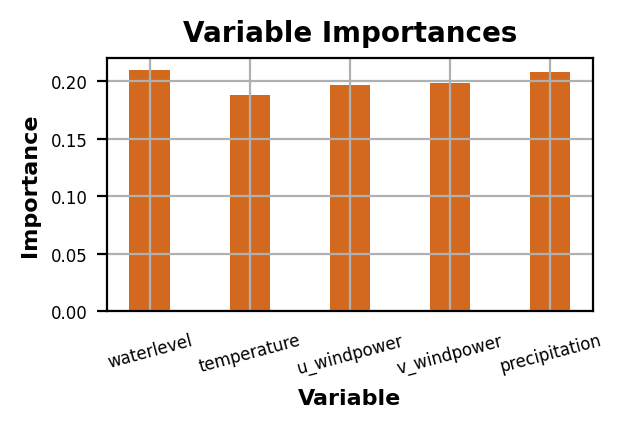

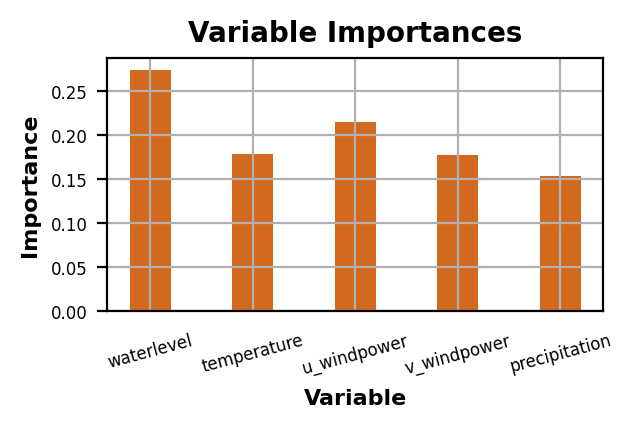

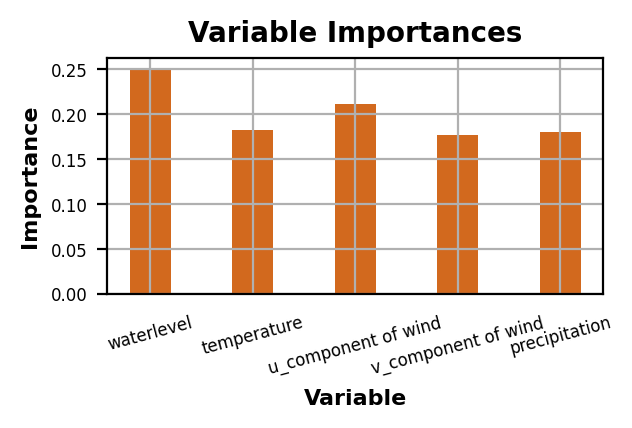

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=688; total time=  25.3s
[CV] END bootstrap=True, max_depth=55, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=466; total time=   0.0s
[CV] END bootstrap=True, max_depth=55, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=466; total time=   0.0s
[CV] END bootstrap=True, max_depth=55, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=466; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=466; total time=  13.2s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=744; total time=  32.7s
[CV] END bootstrap=True, max_depth=77, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=411; total time=   0.0s
[CV] END bootstrap=True, max_depth=100

[CV] END bootstrap=True, max_depth=77, max_features=auto, min_samples_leaf=6, min_samples_split=9, n_estimators=355; total time=   0.0s
[CV] END bootstrap=True, max_depth=66, max_features=auto, min_samples_leaf=4, min_samples_split=7, n_estimators=577; total time=   0.0s
[CV] END bootstrap=True, max_depth=66, max_features=auto, min_samples_leaf=4, min_samples_split=7, n_estimators=577; total time=   0.0s
[CV] END bootstrap=True, max_depth=66, max_features=auto, min_samples_leaf=4, min_samples_split=7, n_estimators=577; total time=   0.0s
[CV] END bootstrap=True, max_depth=77, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=688; total time=   0.0s
[CV] END bootstrap=True, max_depth=77, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=688; total time=   0.0s
[CV] END bootstrap=True, max_depth=77, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=688; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_feat

In [29]:
if __name__ == '__main__':
    # check whether the script is being run as the main program or if it is being imported as a module into another script
    
    # set the working path of files
    path = '../../Data/'
    
    # Get all the files in the folder of Data
    fileList = os.listdir(path)
    
    #
    get_key = lambda i: i.split('.')[0]
    new_sort = sorted(fileList, key=get_key)
    print(fileList, '\n', new_sort)
    n = 0
    
    # Output working path
    # file path to store the visualization of prediction vs actual data
    outpathfigure1 = '../../Output/'
    #file path to store the visualization of feature importance, bar chart
    outpathfigure2 = '../../Output/'
    #file path to store the excel file which includes calculated feature importance
    outpathexcel = '../../Output/'
    
    # change the working path to dataframe after exploratory data analysis. 
    
    #initialize a dataframe first 
    df = pd.DataFrame()
    
    #for i in fileList:
    for i in range(len(fileList)):
    #for i in [1]:
        # get each file
        #file = new_sort[n]
        file = new_sort[i]
        
        # read the excel file and generate a dataframe
        
        features = pd.read_excel(path+file,engine='openpyxl')
        print(features.head(5))
         
        # get the filename
        filename = file.split('.', 1)[0]
        print("\n")
        print('Now Processing ：'+filename + ' Dataset')
        
        # Generate the target data
        labels = np.array(features['coherence'])
        #labels[:] = np.nan_to_num(labels)
        
        # Generate the station name
        stations_name = np.array((features['station']))
        
        # Remove the labels from the features, only remain the environmental variables for features
        features = features.drop(['coherence', 'X', 'Y', 'station','year','month','day'], axis=1)
        
        # Saving feature names for later use, save the column names
        feature_list = list(features.columns)
        
        # Convert to numpy array
        #features[:]=np.nan_to_num(features)
        features = np.array(features)

        # Random Forest Model, call the function "randomforest_regressor"
        importances, predictions, train_features, test_features, train_labels, test_labels, RMSE, R2, MAE = randomforest_regressor(
            features, labels)
        print(importances)
        
        # press ctrl + / to comment the selection of codes
        
        filenamepdViz = filename + 'pdViz'
        
        filenameimpViz = filename +'impViz'
        
        #predictions_Visualized(test_labels,predictions,outpathfigure2, filenamepdViz)
        
        importance_Visualized(importances, feature_list, outpathfigure1, filenameimpViz)
        
        df = importance_excel(importances, feature_list, RMSE, R2, n, df, filename)
        n += 1
        # save the results into a new excel file
        writer = pd.ExcelWriter(outpathexcel + filename + '_MLresults' + '.xlsx', engine='xlsxwriter')
        # options={'strings_to_urls': False})  # 
        df.to_excel(writer, index=False)
        writer._save()
        print('Done!')

    
    # Conduct Hyperparameter Tuning and evaluate the differences

#     #predictions_Visualized(labels,predictions,test_labels)
#     rf_random=randomizeSearchCVdf(train_features,train_labels)
#     evaluate(rf_random,test_features, test_labels)
    


### Conduct Randomized Search Hyperparameter Tuning for training based on datasets "dvalue_all_"  

In [30]:
    # Conduct RandomizedSearch Hyperparameter Tuning for training based on datasets "dvalue_all_"  
    #predictions_Visualized(labels,predictions,test_labels)
    rf_random=randomizeSearchCVdf(train_features,train_labels)
    evaluate(rf_random,test_features, test_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 522, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 77, 'bootstrap': False}
Root Mean Squared Error: 0.19366500147712948
R_Squared: 0.435427011527334
Mean Absolute Error: 0.1388013436306209
[CV] END bootstrap=True, max_depth=55, max_features=auto, min_samples_leaf=6, min_samples_split=8, n_estimators=688; total time=   0.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=5, min_samples_split=7, n_estimators=633; total time=   0.0s
[CV] END bootstrap=True, max_depth=55, max_features=auto, min_samples_leaf=5, min_samples_split=7, n_estimators=744; total time=   0.0s
[CV] END bootstrap=False, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=800; total time=  36.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=355; total time=  10.3s
[CV] EN

[CV] END bootstrap=True, max_depth=77, max_features=auto, min_samples_leaf=6, min_samples_split=9, n_estimators=355; total time=   0.0s
[CV] END bootstrap=True, max_depth=94, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=522; total time=  14.0s
[CV] END bootstrap=False, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=9, n_estimators=577; total time=  24.7s
[CV] END bootstrap=True, max_depth=77, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=411; total time=   0.0s
[CV] END bootstrap=True, max_depth=77, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=411; total time=   0.0s
[CV] END bootstrap=False, max_depth=72, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=355; total time=  14.0s
[CV] END bootstrap=False, max_depth=72, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, n_estimators=355; total time=  13.9s
[CV] END bootstrap=True, max_depth=50, max

[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=744; total time=  33.9s
[CV] END bootstrap=False, max_depth=55, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=800; total time=  32.8s
[CV] END bootstrap=False, max_depth=55, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=800; total time=  34.9s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=744; total time=  31.7s
[CV] END bootstrap=True, max_depth=72, max_features=auto, min_samples_leaf=6, min_samples_split=9, n_estimators=466; total time=   0.0s
[CV] END bootstrap=True, max_depth=72, max_features=auto, min_samples_leaf=6, min_samples_split=9, n_estimators=466; total time=   0.0s
[CV] END bootstrap=True, max_depth=72, max_features=auto, min_samples_leaf=6, min_samples_split=9, n_estimators=466; total time=   0.0s
[CV] END bootstrap=True, max_depth=77, max

[CV] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=3, min_samples_split=7, n_estimators=577; total time=  17.1s
[CV] END bootstrap=True, max_depth=83, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=633; total time=  19.5s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=9, n_estimators=355; total time=  15.4s
[CV] END bootstrap=False, max_depth=77, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=  15.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=7, n_estimators=300; total time=  10.4s
[CV] END bootstrap=True, max_depth=94, max_features=sqrt, min_samples_leaf=6, min_samples_split=9, n_estimators=633; total time=  18.4s
[CV] END bootstrap=True, max_depth=83, max_features=sqrt, min_samples_leaf=3, min_samples_split=9, n_estimators=577; total time=  19.1s
[CV] END bootstrap=True, max_depth=55, max_

[CV] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=3, min_samples_split=7, n_estimators=577; total time=  17.0s
[CV] END bootstrap=True, max_depth=83, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=633; total time=  19.0s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=9, n_estimators=355; total time=  15.6s
[CV] END bootstrap=False, max_depth=77, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=  14.0s
[CV] END bootstrap=True, max_depth=77, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=355; total time=  10.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=7, n_estimators=300; total time=   9.0s
[CV] END bootstrap=True, max_depth=66, max_features=sqrt, min_samples_leaf=3, min_samples_split=7, n_estimators=633; total time=  19.3s
[CV] END bootstrap=True, max_depth=88, max

### Conduct Grid Search Hyperparameter Tuning for training based on datasets "dvalue_all_"  

In [33]:
    
    rf_grid=gridSearchCVdf(train_features,train_labels)
    evaluate(rf_grid, test_features, test_labels)


Fitting 3 folds for each of 1008 candidates, totalling 3024 fits
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=7, n_estimators=350; total time=   9.7s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   8.2s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=9, n_estimators=250; total time=   6.8s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=9, n_estimators=500; total time=  13.7s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=7, n_estimators=250; total time=   6.8s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=7, n_estimators=500; total time=  13.5s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=9, n_estimators=200; total time=   5.4s
[CV]

[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=7, n_estimators=400; total time=  12.2s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=  11.7s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=9, n_estimators=500; total time=  14.5s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=7, n_estimators=200; total time=   5.8s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=7, n_estimators=400; total time=  11.3s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=400; total time=  11.4s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   5.6s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_l

[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=7, n_estimators=350; total time=   9.8s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   8.4s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=9, n_estimators=250; total time=   7.0s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=9, n_estimators=500; total time=  13.8s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=7, n_estimators=250; total time=   6.9s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=7, n_estimators=500; total time=  13.8s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=9, n_estimators=250; total time=   6.8s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_le

[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=7, n_estimators=200; total time=   5.7s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=7, n_estimators=500; total time=  14.0s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=9, n_estimators=250; total time=   7.0s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time=   5.7s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=350; total time=   9.6s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=7, n_estimators=350; total time=   9.5s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=   8.2s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_

[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=7, n_estimators=400; total time=  11.3s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=350; total time=   9.8s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=9, n_estimators=350; total time=   9.8s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   8.2s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=7, n_estimators=300; total time=   8.2s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200; total time=   5.4s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=350; total time=   9.6s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_l

[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=7, n_estimators=300; total time=   9.1s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   8.8s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=9, n_estimators=200; total time=   6.0s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=9, n_estimators=400; total time=  11.7s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500; total time=  14.7s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=   8.5s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=9, n_estimators=200; total time=   5.7s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_l

[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=7, n_estimators=300; total time=   8.7s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=250; total time=   7.2s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=9, n_estimators=200; total time=   5.7s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=9, n_estimators=350; total time=  10.1s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=350; total time=   9.9s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=7, n_estimators=350; total time=  10.0s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=   8.7s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_l

[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=7, n_estimators=400; total time=  11.1s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=350; total time=   9.8s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=9, n_estimators=350; total time=   9.6s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   8.2s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=7, n_estimators=250; total time=   6.8s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=7, n_estimators=500; total time=  13.6s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=9, n_estimators=250; total time=   6.8s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_l

[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=7, n_estimators=500; total time=  14.0s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=  14.4s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=250; total time=   6.9s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500; total time=  13.7s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200; total time=   5.5s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=400; total time=  10.9s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=9, n_estimators=400; total time=  10.8s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_

[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=  11.6s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=3, min_samples_split=9, n_estimators=400; total time=  11.6s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400; total time=  11.5s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=7, n_estimators=500; total time=  14.3s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=9, n_estimators=250; total time=   6.9s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=9, n_estimators=500; total time=  14.4s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=7, n_estimators=200; total time=   5.5s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_l

[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=350; total time=  10.0s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=7, n_estimators=350; total time=   9.6s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=350; total time=   9.6s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=9, n_estimators=300; total time=   8.2s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=250; total time=   6.7s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500; total time=  13.7s
[CV] END bootstrap=True, max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=500; total time=  21.2s
[CV] END bootstrap=True, max_depth=30, max_features=3, min_samples

[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   8.4s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=7, n_estimators=250; total time=   6.8s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=7, n_estimators=500; total time=  13.5s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=9, n_estimators=250; total time=   6.8s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=9, n_estimators=500; total time=  13.5s
[CV] END bootstrap=True, max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=200; total time=   8.5s
[CV] END bootstrap=True, max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=400; total time=  17.0s
[CV] END bootstrap=True, max_depth=30, max_features=3, min_samples_l

[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  12.0s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=7, n_estimators=400; total time=  11.4s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=  14.3s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   8.4s
[CV] END bootstrap=True, max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=200; total time=   9.0s
[CV] END bootstrap=True, max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=500; total time=  22.2s
[CV] END bootstrap=True, max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=9, n_estimators=200; total time=   8.7s
[CV] END bootstrap=True, max_depth=30, max_features=3, min_samples_

[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=400; total time=  11.9s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=9, n_estimators=500; total time=  14.7s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=7, n_estimators=250; total time=   7.0s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=7, n_estimators=500; total time=  14.3s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=9, n_estimators=250; total time=   7.2s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=9, n_estimators=500; total time=  14.5s
[CV] END bootstrap=True, max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=250; total time=  11.1s
[CV] END bootstrap=True, max_depth=30, max_features=3, min_samples_le

[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=9, n_estimators=400; total time=  11.0s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  11.3s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=7, n_estimators=400; total time=  10.8s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=  13.5s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   5.5s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=350; total time=   9.6s
[CV] END bootstrap=True, max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=350; total time=  14.7s
[CV] END bootstrap=True, max_depth=30, max_features=3, min_samples

[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=9, n_estimators=350; total time=  10.3s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=350; total time=  10.1s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=7, n_estimators=300; total time=   8.5s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=250; total time=   7.2s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=9, n_estimators=200; total time=   5.8s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=9, n_estimators=350; total time=  10.1s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   8.6s
[CV] END bootstrap=True, max_depth=30, max_features=3, min_samples_

[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200; total time=   5.4s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=400; total time=  10.9s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=9, n_estimators=400; total time=  11.0s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=  11.0s
[CV] END bootstrap=True, max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=400; total time=  17.3s
[CV] END bootstrap=True, max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=  21.1s
[CV] END bootstrap=True, max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time=   8.3s
[CV] END bootstrap=True, max_depth=30, max_features=3, min_samples_

[CV] END bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=4, min_samples_split=9, n_estimators=400; total time=  16.2s
[CV] END bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=5, min_samples_split=7, n_estimators=200; total time=   8.3s
[CV] END bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=5, min_samples_split=7, n_estimators=400; total time=  15.8s
[CV] END bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=5, min_samples_split=9, n_estimators=250; total time=   7.3s
[CV] END bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=5, min_samples_split=9, n_estimators=400; total time=  11.9s
[CV] END bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500; total time=  14.2s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=400; total time=  18.6s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_l

[CV] END bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=250; total time=   7.1s
[CV] END bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=400; total time=  11.3s
[CV] END bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=5, min_samples_split=9, n_estimators=400; total time=  11.2s
[CV] END bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=  11.3s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=350; total time=  15.2s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=350; total time=  15.1s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=9, n_estimators=300; total time=  12.9s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_l

[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=350; total time=  14.9s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=9, n_estimators=300; total time=  12.6s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=250; total time=  10.4s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=400; total time=  16.9s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=7, n_estimators=400; total time=  16.6s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=350; total time=  14.6s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=9, n_estimators=300; total time=  12.3s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_

[CV] END bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=350; total time=  14.6s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=400; total time=  21.2s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=9, n_estimators=200; total time=   8.9s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=9, n_estimators=300; total time=  13.6s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=250; total time=  14.2s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=7, n_estimators=200; total time=   8.7s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=7, n_estimators=350; total time=  15.3s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_

[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=400; total time=  17.1s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=  17.1s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=9, n_estimators=400; total time=  16.7s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=350; total time=  14.7s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=7, n_estimators=300; total time=  12.4s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=250; total time=  10.3s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500; total time=  20.5s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_l

[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=7, n_estimators=350; total time=  17.6s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=350; total time=  23.3s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=9, n_estimators=500; total time=  25.6s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=7, n_estimators=300; total time=  13.4s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200; total time=   8.9s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=400; total time=  23.6s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  12.8s
[CV] END bootstrap=True, max_depth=40, max_features=3, min_samples_l

{'bootstrap': True, 'max_depth': 25, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 300}
Root Mean Squared Error: 0.19719419831751517
R_Squared: 0.4146628676660372
Mean Absolute Error: 0.14872970015627607


### Conduct Grid Search Hyperparameter Tuning for training based on datasets "dvalue_all_"  

In [34]:

    rf_bayes=bayesSearchCVdf(train_features,train_labels)
    evaluate(rf_bayes, test_features, test_labels)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations